Notebook Color Scheme:


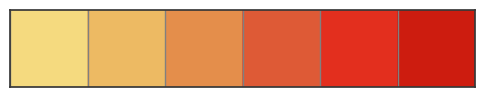

In [1]:
# Core
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set(style="whitegrid", rc={"axes.edgecolor":"#383838", "grid.color": "#808080"}, font_scale=1.6)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from bs4 import BeautifulSoup
import re

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Color scheme
my_colors = ["#F5DA7F", "#EDBA63", "#E48E4B", "#DE5A36", "#E32F1E", "#CD1C0F"]
CMAP1 = ListedColormap(my_colors)
print("Notebook Color Scheme:")
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [3]:
# Load data into a pandas data frame
data = pd.read_csv("/content/IMDB.csv")

# Preview data frame and shape
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Print first review
print("Sentiment:", data.loc[0,"sentiment"])
print("\nReview:", data.loc[0,"review"])

Sentiment: positive

Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal 

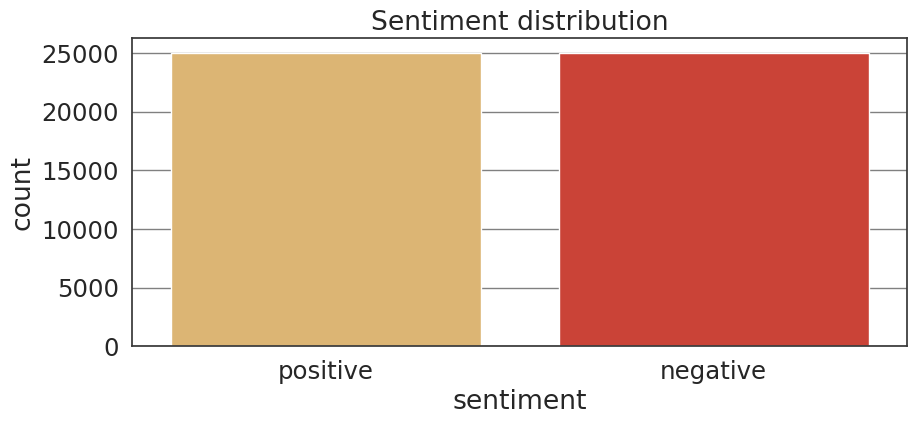

In [5]:
plt.figure(figsize=(10,4))
sns.countplot(data=data, x="sentiment", palette = [my_colors[1],my_colors[4]])
plt.title("Sentiment distribution")
plt.show()

In [6]:
# Print target distribution
data["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


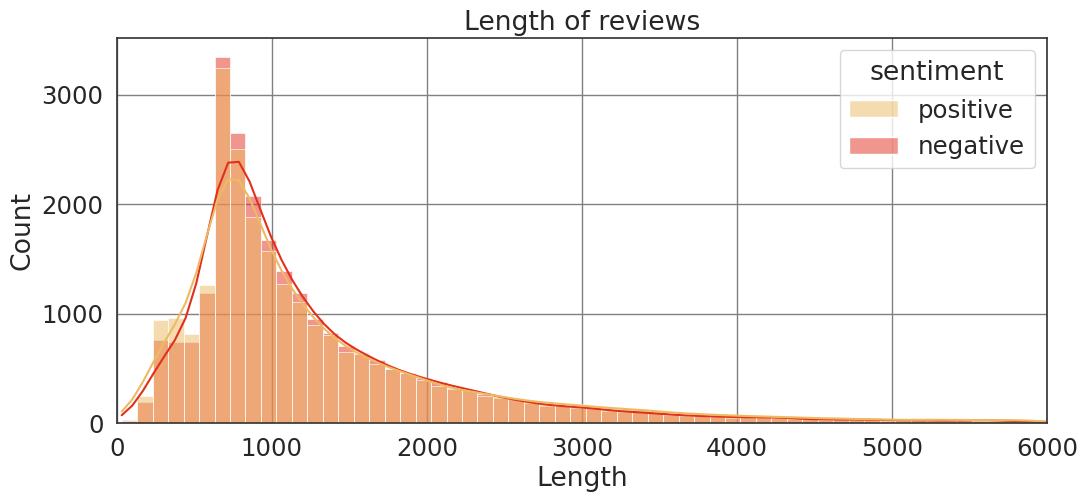

In [7]:
# Calculate length of each review
len_data = pd.concat([data.loc[:,"review"].map(lambda x:len(x)),data.loc[:,"sentiment"]],axis=1)

# Plot distribution
plt.figure(figsize=(12,5))
sns.histplot(data=len_data, x="review", hue="sentiment", palette = [my_colors[1],my_colors[4]], binwidth=100, kde=True)
plt.title("Length of reviews")
plt.xlabel("Length")
plt.xlim([0,6000])
plt.show()

In [8]:
print("Average positive review length:", len_data.loc[len_data["sentiment"]=="positive","review"].mean())
print("Average negative review length:", len_data.loc[len_data["sentiment"]=="negative","review"].mean())

Average positive review length: 1324.79768
Average negative review length: 1294.06436


In [10]:
# Pre-processing
#3.1 Clean data
#Let's clean the data by removing html tags, which can be done by using the BeautifulSoup library. We'll also remove urls and special characters.

def remove_html_tags(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

def remove_urls(text):
    return re.sub("http\S+","",text)

def remove_special_characters(text):
    return re.sub("[^A-Za-z0-9 ]+","",text)

def clean_text(text):
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_special_characters(text)
    return text

In [12]:
%%time

# Clean entire dataset
data["review"] = data["review"].apply(clean_text)

CPU times: user 10.2 s, sys: 108 ms, total: 10.3 s
Wall time: 11.8 s


In [13]:
# Print first review after data cleaning
data.loc[0,"review"]

'One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to manyAryans Muslims gangstas Latinos Christians Italians Irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pretty pictur

In [14]:
#3.2 Encode target
#We need to convert the target to integers. We map positive to 1 and negative to 0.

data["sentiment"] = data["sentiment"].replace("positive",1).replace("negative",0)



In [15]:
#3.3 Split data
#We need to create a test set to be able to evaluate our models.

# Split features and labels
X = data["review"]
y = data["sentiment"]

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# Print train target distribution
print(y_train.value_counts())



sentiment
1    20000
0    20000
Name: count, dtype: int64


In [16]:
#3.4 Tokenization
#We're going to build a custom tokenizer using spacy. We'll remove stop words (i.e. common words with little meaning) and apply lemmatization
#(i.e. convert words to dictionary form), which are common NLP preprocessing techniques. Furthermore, we only keep tokens if they are an adjective,
#proper noun or verb to reduce the size of the vocabulary.

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Disable named-entity recognition and parsing to save time
unwanted_pipes = ["ner", "parser"]

# Custom tokenizer using spacy
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in nlp(doc) if not t.is_stop and not t.is_space and t.pos_ in ["ADJ","NOUN","VERB"]]



In [23]:
%%time

# Bag-of-Words vectorizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

# Fit and transform train data
X_train_bow = vectorizer.fit_transform(X_train)

# Transform test data
X_test_bow = vectorizer.transform(X_test)

# Print vocab size
print("BoW vocabulary size:", X_train_bow.shape[1])

BoW vocabulary size: 133448
CPU times: user 16min 34s, sys: 2.81 s, total: 16min 37s
Wall time: 16min 48s


In [24]:
%%time

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

# Fit and transform train data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = vectorizer.transform(X_test)

# Print vocab size
print("TF-IDF vocabulary size:", X_train_tfidf.shape[1])

TF-IDF vocabulary size: 133448
CPU times: user 16min 26s, sys: 2.56 s, total: 16min 29s
Wall time: 16min 36s


In [25]:
#4. Modelling with Naive Bayes¶
#4.1 Using BoW vectors
#Our first model will be Naive Bayes on the Bag-of-Words (BoW) vectorized data. We'll also tune the additive smoothing hyperparameter alpha using grid search.

%%time

# Parameters to tune
grid = {"alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]}

# Define model
clf = MultinomialNB()

# Define grid search
nb_bow = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

# Train model using grid search
nb_bow.fit(X_train_bow, y_train)

# Print best value of alpha
print("Best parameters:", nb_bow.best_params_)



Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'alpha': 0.5}
CPU times: user 247 ms, sys: 161 ms, total: 407 ms
Wall time: 5.4 s


In [26]:
# Make predictions on test set
nb_bow_preds = nb_bow.predict(X_test_bow)

# Print classification report
print(classification_report(y_test, nb_bow_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      5000
    positive       0.86      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



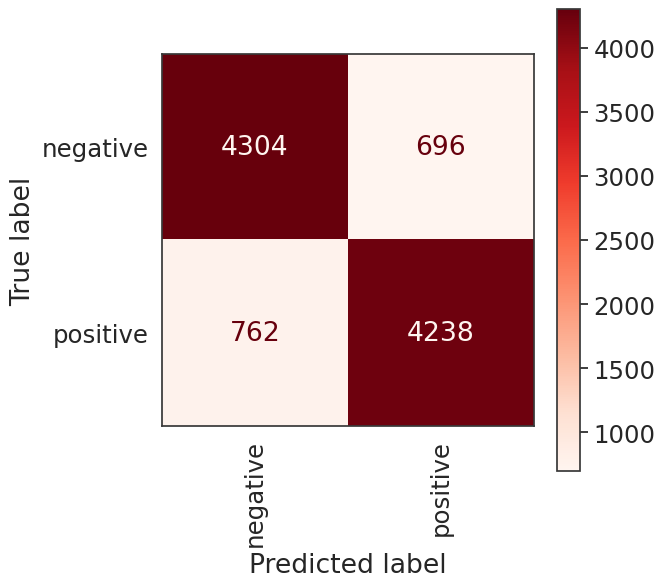

In [27]:
# Figure size
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

# Create the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(nb_bow, X_test_bow, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)

In [28]:
#Now we'll apply Naive Bayes on the TF-IDF vectorized data. Let's see how it compares to using Bag-of-Words.

%%time

# Parameters to tune
grid = {"alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]}

# Define model
clf = MultinomialNB()

# Define grid search
nb_tfidf = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

# Train model using grid search
nb_tfidf.fit(X_train_tfidf, y_train)

# Print best value of alpha
print("Best parameters:", nb_tfidf.best_params_)



Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'alpha': 1.0}
CPU times: user 253 ms, sys: 48.9 ms, total: 302 ms
Wall time: 4.14 s


In [29]:
# Make predictions on test set
nb_tfidf_preds = nb_tfidf.predict(X_test_tfidf)

# Print classification report
print(classification_report(y_test, nb_tfidf_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.86      0.86      0.86      5000
    positive       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



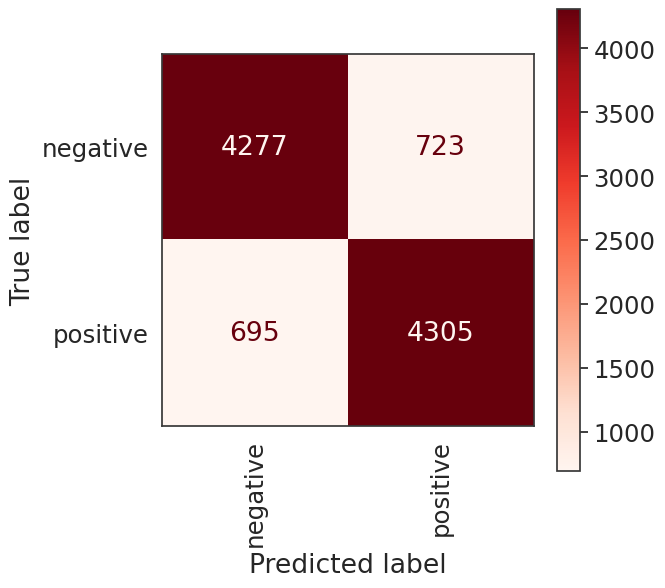

In [30]:
# Figure size
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

# Create the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(nb_tfidf, X_test_tfidf, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)

In [31]:
#5. Modelling with Logistic Regression¶
#5.1 Using BoW vectors
#Now we'll use a Logistic Regression model on the Bag-of-Words vectorized data to see how it compares to Naive Bayes. We'll also tune the regularization hyperparameters of the model.

%%time

# Parameters to tune
grid = {"penalty": ["l1","l2"], "solver": ["liblinear"], "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5]}

# Define model
clf = LogisticRegression()

# Define grid search
lr_bow = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

# Train model using grid search
lr_bow.fit(X_train_bow, y_train)

# Print best value of alpha
print("Best parameters:", lr_bow.best_params_)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 0.25, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: user 18.4 s, sys: 517 ms, total: 18.9 s
Wall time: 4min 13s


In [32]:
# Make predictions on test set
lr_bow_preds = lr_bow.predict(X_test_bow)

# Print classification report
print(classification_report(y_test, lr_bow_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      5000
    positive       0.87      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



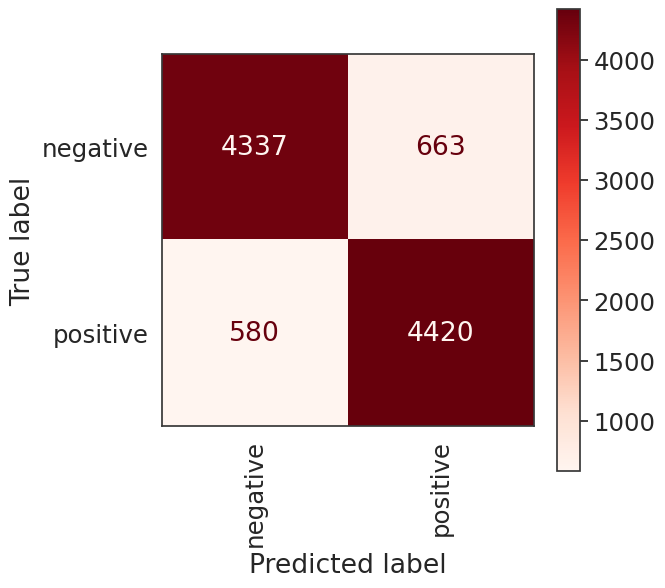

In [33]:
# Figure size
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

# Create the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(lr_bow, X_test_bow, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)

In [34]:
%%time

# Parameters to tune
grid = {"penalty": ["l1","l2"], "solver": ["liblinear"], "C": [0.25, 0.5, 0.75, 1, 1.25, 1.5]}

# Define model
clf = LogisticRegression()

# Define grid search
lr_tfidf = GridSearchCV(clf, param_grid=grid, scoring="f1_macro", n_jobs=-1, cv=5, verbose=5)

# Train model using grid search
lr_tfidf.fit(X_train_tfidf, y_train)

# Print best value of alpha
print("Best parameters:", lr_tfidf.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1.5, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: user 4.18 s, sys: 186 ms, total: 4.36 s
Wall time: 58 s


In [35]:
# Make predictions on test set
lr_tfidf_preds = lr_tfidf.predict(X_test_tfidf)

# Print classification report
print(classification_report(y_test, lr_tfidf_preds, target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      5000
    positive       0.87      0.90      0.89      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



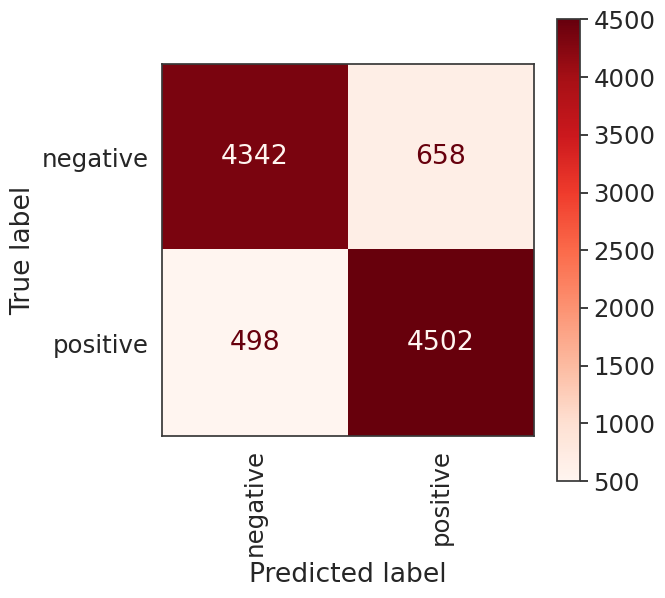

In [36]:
# Figure size
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid(False)

# Create the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(lr_tfidf, X_test_tfidf, y_test, cmap="Reds", display_labels=["negative","positive"], xticks_rotation="vertical", ax=ax)